В лабораторной работе проверялся закон Стефана-Больцмана $R =\sigma T^n$.
Потребляемая лампой накаливания мощность (следовательно, и излучаемая мощность $P = RS$) измерялась амперметром и вольтметром, а температура
нити- оптическим пирометром.
Излучающая площадь нитей накаливания равна $1 см^2$.

При разных токах получено следующее:
|$t, ^{\circ}C$|700|900|1100|1300|1500|1700|1900|
|:-----:|:-:|:-:|:-:|:-:|:--:|:--:|:--:|
|$P, Вт$|11|23|47|61|82|120|170|

С помощью интерполяции найти мощность при $t = 800^{\circ}C, 1000^{\circ}C$

Значение мощности при t = 800°C: P = 11 Вт
Значение мощности при t = 1000°C: P = 37 Вт


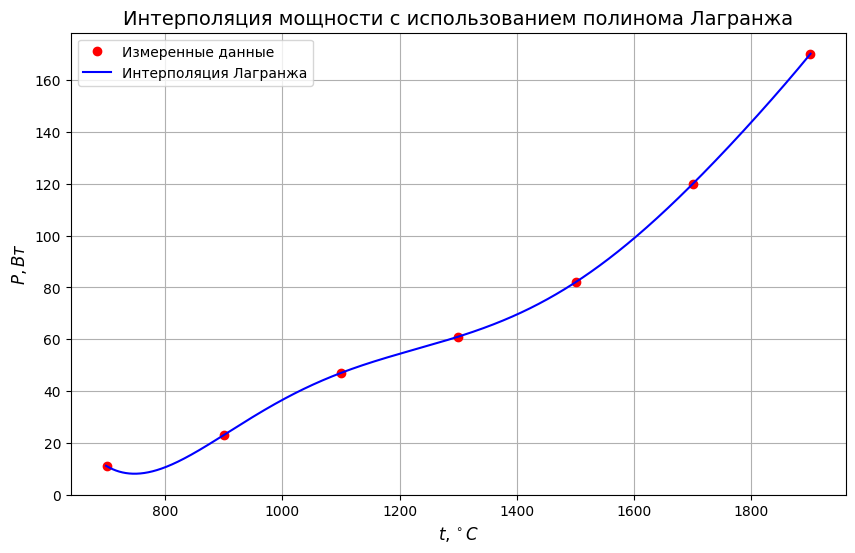

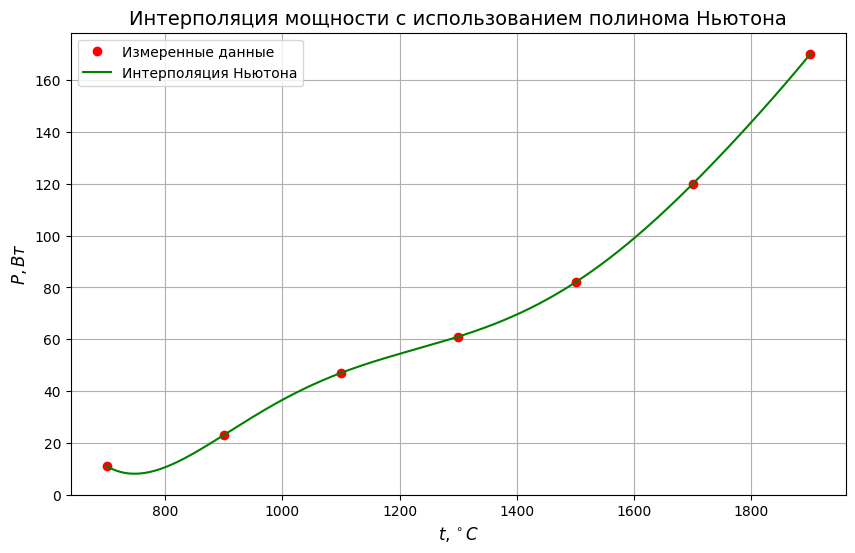

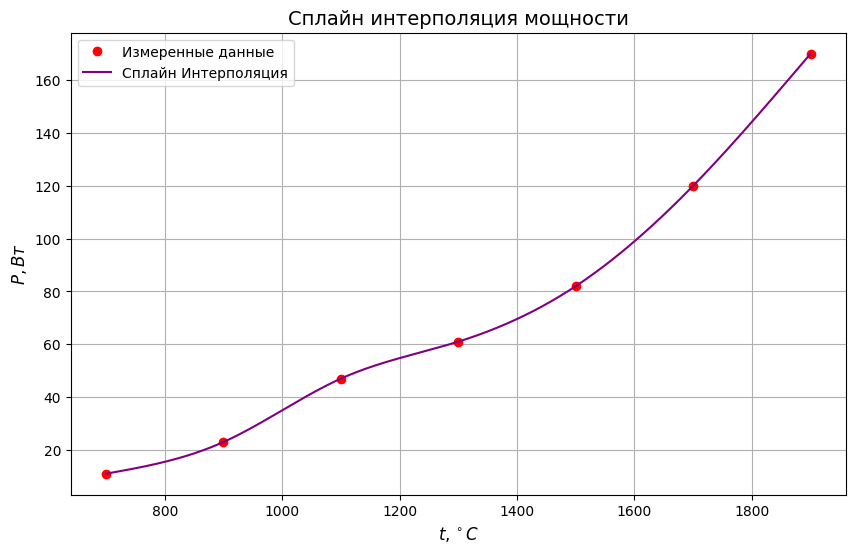

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod


class InterpolationMethod(ABC):
    @abstractmethod
    def interpolate(self, t: float) -> float:
        pass


class LagrangeInterpolation(InterpolationMethod):
    def __init__(self, t_vals, P_vals):
        self.t_vals = t_vals
        self.P_vals = P_vals

    def basis_polynomial(self, t, i):
        termL = 1
        for j in range(len(self.t_vals)):
            if i != j:
                termL *= (t - self.t_vals[j]) / (self.t_vals[i] - self.t_vals[j])
        return termL

    def interpolate(self, t):
        return sum(self.P_vals[i] * self.basis_polynomial(t, i) for i in range(len(self.t_vals)))

class NewtonInterpolation(InterpolationMethod):
    def __init__(self, t_vals, P_vals):
        self.t_vals = t_vals
        self.P_vals = P_vals
        self.divided_differences = self.compute_divided_differences()
        

    def compute_divided_differences(self):
        n = len(self.t_vals)
        diffs = [list(self.P_vals)]
        for j in range(1, n):
            row = []
            for i in range(n - j):
                diff = (diffs[j-1][i+1] - diffs[j-1][i]) / (self.t_vals[i+j] - self.t_vals[i])
                row.append(diff)
            diffs.append(row)
        return diffs

    def partial_summ(self, t, i):
        termN = 1
        for j in range(i):
            termN *= (t - self.t_vals[j])
        return termN
    
    def interpolate(self, t):
        result = self.P_vals[0]
        for i in range(1, len(self.t_vals)):
            result += self.divided_differences[i][0] * self.partial_summ(t, i)
        return result
class SplineInterpolation(InterpolationMethod):
    def __init__(self, t_vals, P_vals):
        self.t_vals = t_vals
        self.P_vals = P_vals
        self.n = len(t_vals) - 1
        self.h = [t_vals[i+1] - t_vals[i] for i in range(self.n)]
        self.a = P_vals[:]
        self.c, self.b, self.d = self.compute_spline_coefficients()
        
    def compute_spline_coefficients(self):
        A = np.zeros((self.n + 1, self.n + 1))
        B = np.zeros(self.n + 1)
        
        for i in range(1, self.n):
            A[i][i-1] = self.h[i-1]
            A[i][i] = 2 * (self.h[i-1] + self.h[i])
            A[i][i+1] = self.h[i]
            B[i] = 3 * ((self.a[i+1] - self.a[i]) / self.h[i] - (self.a[i] - self.a[i-1]) / self.h[i-1])

        A[0][0] = 1
        A[self.n][self.n] = 1

        c = np.linalg.solve(A, B)
        b = [(self.a[i+1] - self.a[i]) / self.h[i] - (2*c[i] + c[i+1]) * self.h[i] / 3 for i in range(self.n)]
        d = [(c[i+1] - c[i]) / (3 * self.h[i]) for i in range(self.n)]
        
        return c, b, d
        
    def interpolate(self, t):
        for i in range(self.n):
            if self.t_vals[i] <= t <= self.t_vals[i+1]:
                dx = t - self.t_vals[i]
                return self.a[i] + self.b[i] * dx + self.c[i] * dx**2 + self.d[i] * dx**3
        return None


            


# Данные
t_vals = [700, 900, 1100, 1300, 1500, 1700, 1900]
P_vals = [11, 23, 47, 61, 82, 120, 170]
t_val_800 = 800  # Значение температуры для интерполяции
t_val_1000 = 1000  # Значение температуры для интерполяции

#Метод Лагранжа
interpolator = LagrangeInterpolation(t_vals, P_vals)
P_800 = interpolator.interpolate(t_val_800)
P_1000 = interpolator.interpolate(t_val_1000)
print(f'Значение мощности при t = {t_val_800}°C: P = {P_800:.0f} Вт')
print(f'Значение мощности при t = {t_val_1000}°C: P = {P_1000:.0f} Вт')

#Метод Ньютона
interpolator1 = NewtonInterpolation(t_vals, P_vals)
P_800_N = interpolator1.interpolate(t_val_800)
P_1000_N = interpolator1.interpolate(t_val_1000)

#Сплайн Метод
interpolator2 = SplineInterpolation(t_vals, P_vals)
P_800_N = interpolator2.interpolate(t_val_800)
P_1000_N = interpolator2.interpolate(t_val_1000)



#Построение Графиков
t_plot = np.linspace(699, 1901, 3000)
P_plot = [interpolator.interpolate(t) for t in t_plot]
P_plot1 = [interpolator1.interpolate(t) for t in t_plot]
P_plot2 = [interpolator2.interpolate(t) for t in t_plot]



#График для Лагранжа
plt.figure(figsize=(10, 6))
plt.plot(t_vals, P_vals, 'o', label='Измеренные данные', color='red')# Измеренные данные
plt.plot(t_plot, P_plot, label='Интерполяция Лагранжа', color='blue')  # Интерполяция Лагранжа
plt.xlabel(r'$t, ^\circ C$', fontsize=12)
plt.ylabel(r'$P, Вт$', fontsize=12)
plt.title('Интерполяция мощности с использованием полинома Лагранжа', fontsize=14)
plt.grid()
plt.legend()
plt.show()

#График для Ньютона
plt.figure(figsize=(10,6))
plt.plot(t_vals, P_vals, 'o', label='Измеренные данные', color='red')# Измеренные данные
plt.plot(t_plot, P_plot1, label='Интерполяция Ньютона', color='green')  # Интерполяция Ньютона
plt.xlabel(r'$t, ^\circ C$', fontsize=12)
plt.ylabel(r'$P, Вт$', fontsize=12)
plt.title('Интерполяция мощности с использованием полинома Ньютона', fontsize=14)
plt.grid()
plt.legend()
plt.show()

#График для Сплайн Интепроляции
plt.figure(figsize=(10, 6))
plt.plot(t_vals, P_vals, 'o', label='Измеренные данные', color='red')# Измеренные данные
plt.plot(t_plot, P_plot2, label='Сплайн Интерполяция', color='purple')  # Интерполяция Лагранжа
plt.xlabel(r'$t, ^\circ C$', fontsize=12)
plt.ylabel(r'$P, Вт$', fontsize=12)
plt.title('Сплайн интерполяция мощности', fontsize=14)
plt.grid()
plt.legend()
plt.show()



In [5]:
import dis

def normal_func(x):
    return x * 2

lambda_func = lambda x: x * 2

print(dis.dis(normal_func))
print(dis.dis(lambda_func))

  3           0 RESUME                   0

  4           2 LOAD_FAST                0 (x)
              4 LOAD_CONST               1 (2)
              6 BINARY_OP                5 (*)
             10 RETURN_VALUE
None
  6           0 RESUME                   0
              2 LOAD_FAST                0 (x)
              4 LOAD_CONST               1 (2)
              6 BINARY_OP                5 (*)
             10 RETURN_VALUE
None


In [3]:
def myfunc(n):
  return lambda a : a ** n

mydoubler = myfunc(2)

print(mydoubler(11))

121


In [6]:
def use_map():
    return map(lambda x: x ** 2, [1, 2, 3, 4, 5])

print(dis.dis(use_map))

  1           0 RESUME                   0

  2           2 LOAD_GLOBAL              1 (NULL + map)
             12 LOAD_CONST               1 (<code object <lambda> at 0x0000021C782C1620, file "C:\Users\DEADMAN\AppData\Local\Temp\ipykernel_5524\651578290.py", line 2>)
             14 MAKE_FUNCTION            0
             16 BUILD_LIST               0
             18 LOAD_CONST               2 ((1, 2, 3, 4, 5))
             20 LIST_EXTEND              1
             22 CALL                     2
             30 RETURN_VALUE

Disassembly of <code object <lambda> at 0x0000021C782C1620, file "C:\Users\DEADMAN\AppData\Local\Temp\ipykernel_5524\651578290.py", line 2>:
  2           0 RESUME                   0
              2 LOAD_FAST                0 (x)
              4 LOAD_CONST               1 (2)
              6 BINARY_OP                8 (**)
             10 RETURN_VALUE
None
